# APS Calculator - LDH

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import decimal

## Data

In [2]:
veri1 = pd.read_excel('/Users/hikmetcancubukcu/Desktop/18_65_nhanes_na_drop dosyalar/nhanes_20220711_fasting.xlsx')

### Intra-individual Biological Variation of Analyte

In [3]:
# Analyte CVI value from EFLM
CVI= 5.2
CVI_fraction = CVI/100
# see: https://biologicalvariation.eu/search?query=Lactate%20dehydrogenase%20(LDH)%20activity

In [4]:
# Female gender selection  serum, adult female 135-214 U/L

veri3 = veri1[veri1['Gender']==2] # female : 2
veri3 = veri3.reset_index() # reset index


In [5]:
# Male gender selection  Serum, adult male 135-225 U/L 

veri2 = veri1[veri1['Gender']==1] # male : 1
veri2 = veri2.reset_index() # reset index

### Categorization

In [6]:
# Female data

#  column selection

column_name = 'Lactate Dehydrogenase (LDH) (IU/L)'
analyte_data_f = veri3[column_name]

# Numeric data to categorical data conversion

bins_f = [0, 134, 214, np.inf]
names_f = ['<135', '135-214' ,'>214'] # decision limits
value=[1, 2, 3] # number of category

cat_analyte_f= pd.cut(analyte_data_f, bins_f, labels=names_f)

cat_analyte_df_f= pd.DataFrame(cat_analyte_f)
cat_analyte_df_f

# concat dfs

cat_analyte_df_f = cat_analyte_df_f.rename(columns={column_name: "Analyte_category"})

analyte_last_df_f = pd.concat([analyte_data_f, cat_analyte_df_f],axis = 1)

# Category to number conversion

analyte_last_df_f['cat_n'] = analyte_last_df_f['Analyte_category'].replace(
    to_replace=names_f,
    value=value, inplace=False)
#analyte_last_df_f

In [7]:
# Male data

#  column selection

column_name = 'Lactate Dehydrogenase (LDH) (IU/L)'
analyte_data_m = veri2[column_name]

# Numeric data to categorical data conversion

bins_m = [0, 134, 225, np.inf]
names_m = ['<135', '135-225','>225'] # decision limits
value=[1, 2, 3] # number of category

cat_analyte_m= pd.cut(analyte_data_m, bins_m, labels=names_m)

cat_analyte_df_m= pd.DataFrame(cat_analyte_m)
cat_analyte_df_m

# concat dfs

cat_analyte_df_m = cat_analyte_df_m.rename(columns={column_name: "Analyte_category"})

analyte_last_df_m = pd.concat([analyte_data_m, cat_analyte_df_m],axis = 1)

# Category to number conversion

analyte_last_df_m['cat_n'] = analyte_last_df_m['Analyte_category'].replace(
    to_replace=names_m,
    value=value, inplace=False)
#analyte_last_df_m

(51.0, 749.0)

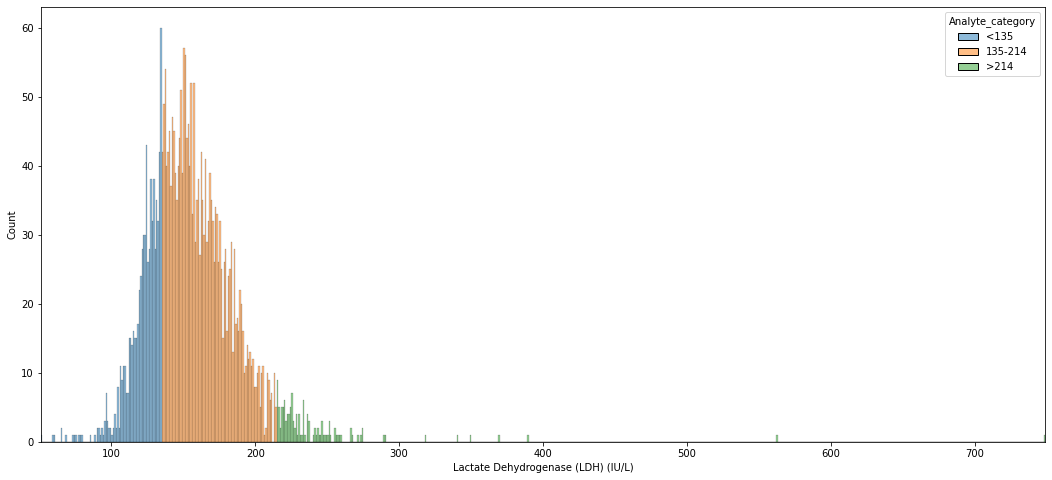

In [8]:
# histogram of female original data

import seaborn as sns
import math

plt.figure(figsize=(18, 8))
sns.histplot(data=analyte_last_df_f, x=column_name, kde=False, hue="Analyte_category",  
              binwidth=1,discrete= False)

plt.xlim(analyte_last_df_f[column_name].min(), analyte_last_df_f[column_name].max())

(49.0, 421.0)

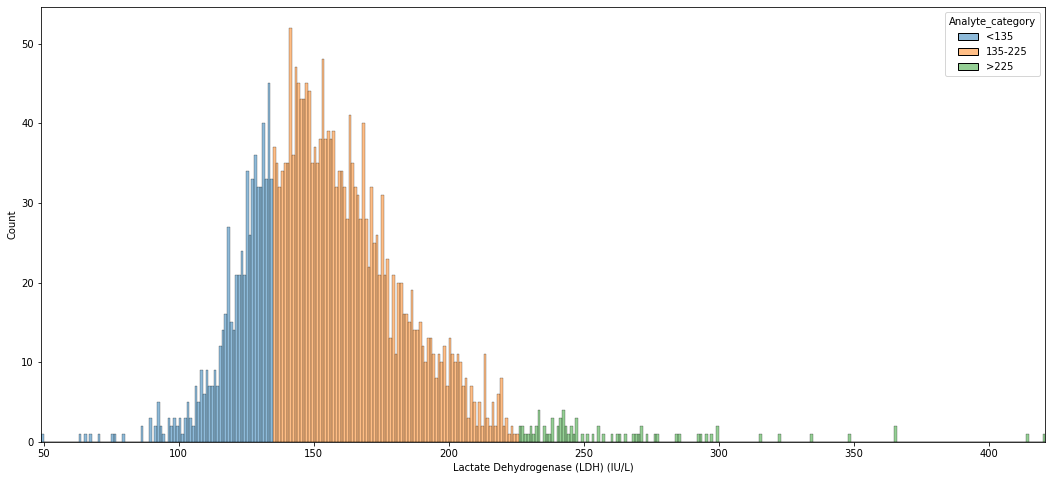

In [9]:
# histogram of male original data

import seaborn as sns
import math

plt.figure(figsize=(18, 8))
sns.histplot(data=analyte_last_df_m, x=column_name, kde=False, hue="Analyte_category",  
              binwidth= 1,discrete= False)

plt.xlim(analyte_last_df_m[column_name].min(), analyte_last_df_m[column_name].max())

## Simulation

In [10]:
# Packages

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from numpy import random
from numpy import mean
from sklearn.metrics import precision_recall_fscore_support
import math 

# Selection of original data and original data category female

od_f = analyte_last_df_f[column_name] # original data
o_cat_n_f = analyte_last_df_f['cat_n'] # original data category

# Selection of original data and original data category male

od_m = analyte_last_df_m[column_name] # original data
o_cat_n_m = analyte_last_df_m['cat_n'] # original data category


names = ['1', '2'] # normal and high interval category for M & F genders

### Imprecision with positive bias simulation

In [11]:
# Imprecision with positive bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)



# positive error simulation


for e in np.arange(0,0.5,0.01): # CV constant
    for f in np.arange(0,0.5,0.01): # bias constant
        
        #female
        n_cat_n_f = []
        o_cat_n_f = list(o_cat_n_f)   
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        n_data_f = len(od_f) # sample size
        np.random.seed(2) # seed for reproducible results
        imprec_data_raw_f = np.random.normal(0, 1, n_data_f) # random number 0 mean 1 sd
        imprec_data_raw_f = pd.Series(imprec_data_raw_f)
        
        
        y_od_f = od_f + od_f*imprec_data_raw_f*e_CVI  # random error + CVI applied
        nd_f = y_od_f + od_f*f # new data, bias applied
        
        nd_cat_f= pd.cut(nd_f, bins_f, labels=names_f) # Categorization of the new data
        nd_cat_n_f = nd_cat_f.replace(to_replace=names_f,
        value=value, inplace=False)
        
        n_cat_n_f.append(nd_cat_n_f)
        n_cat_n_f = [item for sublist in n_cat_n_f for item in sublist]
        
        n_cat_n_f = pd.Series(n_cat_n_f)
        n_cat_n_f = n_cat_n_f.fillna(1)
        
        # male
        n_cat_n_m = []
        
        o_cat_n_m = list(o_cat_n_m)   
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        n_data_m = len(od_m) # sample size
        np.random.seed(2) # seed for reproducible results
        imprec_data_raw_m = np.random.normal(0, 1, n_data_m) # random number 0 mean 1 sd
        imprec_data_raw_m = pd.Series(imprec_data_raw_m)
        
        y_od_m = od_m + od_m*imprec_data_raw_m*e_CVI  # random error + CVI applied
        nd_m = y_od_m + od_m*f # new data, bias applied
        
        nd_cat_m= pd.cut(nd_m, bins_m, labels=names_m) # Categorization of the new data
        nd_cat_n_m = nd_cat_m.replace(to_replace=names_m,
        value=value, inplace=False)
        
        n_cat_n_m.append(nd_cat_n_m)
        n_cat_n_m = [item for sublist in n_cat_n_m for item in sublist]
        
        n_cat_n_m = pd.Series(n_cat_n_m)
        n_cat_n_m = n_cat_n_m.fillna(1)
        
        n_cat_n_f = n_cat_n_f.tolist()
        n_cat_n_m = n_cat_n_m.tolist()
        
        n_cat_n_v2 = n_cat_n_f+n_cat_n_m
        
        o_cat_n_v1=o_cat_n_f+o_cat_n_m # adding 2 orginal category lists (M&F)
        
        
        kappa_score = cohen_kappa_score(o_cat_n_v1, n_cat_n_v2) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(f) # bias rate save
        accuracy = accuracy_score(o_cat_n_v1, n_cat_n_v2) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n_v1, n_cat_n_v2) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names_m

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b,kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Accuracy (Agreement)"]
error_kappa_table_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)

        

### Imprecision with negative bias simulation

In [12]:
# Imprecision with negative bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)



# negative error simulation


for e in np.arange(0,0.5,0.01): # CV constant
    for f in np.arange(0,0.5,0.01): # bias constant
        
        #female
        n_cat_n_f = []
        o_cat_n_f = list(o_cat_n_f)   
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        n_data_f = len(od_f) # sample size
        np.random.seed(2) # seed for reproducible results
        imprec_data_raw_f = np.random.normal(0, 1, n_data_f) # random number 0 mean 1 sd
        imprec_data_raw_f = pd.Series(imprec_data_raw_f)
        
        
        y_od_f = od_f + od_f*imprec_data_raw_f*e_CVI  # random error + CVI applied
        nd_f = y_od_f - od_f*f # new data, bias applied
        
        nd_cat_f= pd.cut(nd_f, bins_f, labels=names_f) # Categorization of the new data
        nd_cat_n_f = nd_cat_f.replace(to_replace=names_f,
        value=value, inplace=False)
        
        n_cat_n_f.append(nd_cat_n_f)
        n_cat_n_f = [item for sublist in n_cat_n_f for item in sublist]
        
        n_cat_n_f = pd.Series(n_cat_n_f)
        n_cat_n_f = n_cat_n_f.fillna(1)
        
        # male
        n_cat_n_m = []
        
        o_cat_n_m = list(o_cat_n_m)   
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        n_data_m = len(od_m) # sample size
        np.random.seed(2) # seed for reproducible results
        imprec_data_raw_m = np.random.normal(0, 1, n_data_m) # random number 0 mean 1 sd
        imprec_data_raw_m = pd.Series(imprec_data_raw_m)
        
        y_od_m = od_m + od_m*imprec_data_raw_m*e_CVI  # random error + CVI applied
        nd_m = y_od_m - od_m*f # new data, bias applied
        
        nd_cat_m= pd.cut(nd_m, bins_m, labels=names_m) # Categorization of the new data
        nd_cat_n_m = nd_cat_m.replace(to_replace=names_m,
        value=value, inplace=False)
        
        n_cat_n_m.append(nd_cat_n_m)
        n_cat_n_m = [item for sublist in n_cat_n_m for item in sublist]
        
        n_cat_n_m = pd.Series(n_cat_n_m)
        n_cat_n_m = n_cat_n_m.fillna(1)
        
        n_cat_n_f = n_cat_n_f.tolist()
        n_cat_n_m = n_cat_n_m.tolist()
        
        n_cat_n_v2 = n_cat_n_f+n_cat_n_m
        
        o_cat_n_v1=o_cat_n_f+o_cat_n_m # adding 2 orginal category lists (M&F)
        
        
        kappa_score = cohen_kappa_score(o_cat_n_v1, n_cat_n_v2) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(-f) # bias rate save
        accuracy = accuracy_score(o_cat_n_v1, n_cat_n_v2) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n_v1, n_cat_n_v2) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names_m

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b,kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Accuracy (Agreement)"]
error_kappa_table_1_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)

        

In [13]:
# Concat positive and negative bias simulation data

error_kappa_table_2 = pd.concat([error_kappa_table_1, error_kappa_table_1_1], axis = 0) # concat positive and negative error simulation data
error_kappa_table_2 = error_kappa_table_2.reset_index() # reset index


## Kappa score categorization

In [14]:
# Kappa score categorization

bins_k = [0, 0.599999999, 0.799999999, 0.9, np.inf]
names_k = ['0-.59','.60-.79', '.80-.90', '>.90']

cat_kappa= pd.cut(error_kappa_table_2['Kappa Score'], bins_k, labels=names_k)

cat_kappa_df= pd.DataFrame(cat_kappa)
cat_kappa_df

# concat dfs

cat_kappa_df = cat_kappa_df.rename(columns={"Kappa Score": "Kappa Category"})

# Outcome full
error_kappa_table_2_v2 = pd.concat([error_kappa_table_2, cat_kappa_df],axis = 1)


# Outcome corresponding Allowable APS

error_kappa_table_3 = error_kappa_table_2_v2[error_kappa_table_2_v2['Kappa Score']>=0.60]


# Visiualisation of Data

## Kappa Score vs Imprecision & Bias
### 3d Scattter Plot

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


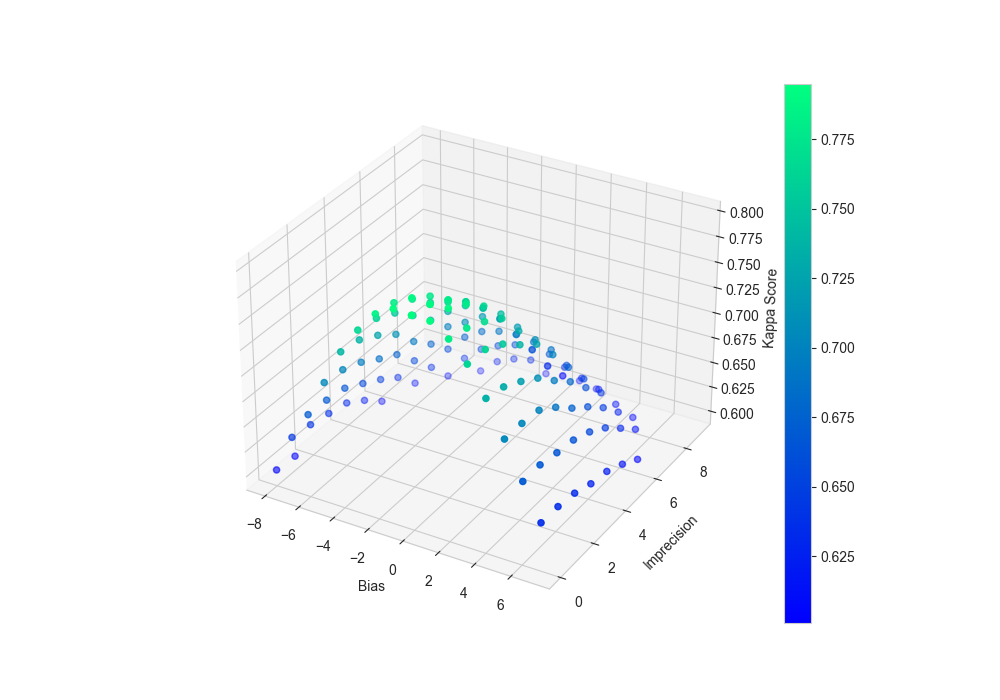

In [15]:
# 3d Scattter Plot

import ipympl
%matplotlib widget
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('whitegrid')
plt.figure(figsize=(10,7))

axes = plt.axes(projection='3d')

color_map = plt.get_cmap('winter')


print(type(axes))
x1 = error_kappa_table_3['Bias']*100 # percentage unit
y1 = error_kappa_table_3['Imprecision']*100 # percentage unit
z1 = error_kappa_table_3['Kappa Score']

scatter_plot= axes.scatter3D(x1, y1, z1, c=(z1),
                            cmap = color_map
                            )

axes.set_xlabel('Bias')
axes.set_ylabel('Imprecision')
axes.set_zlabel('Kappa Score')

axes.view_init()

plt.colorbar(scatter_plot)

plt.show()

## Kappa Category Contour Plot

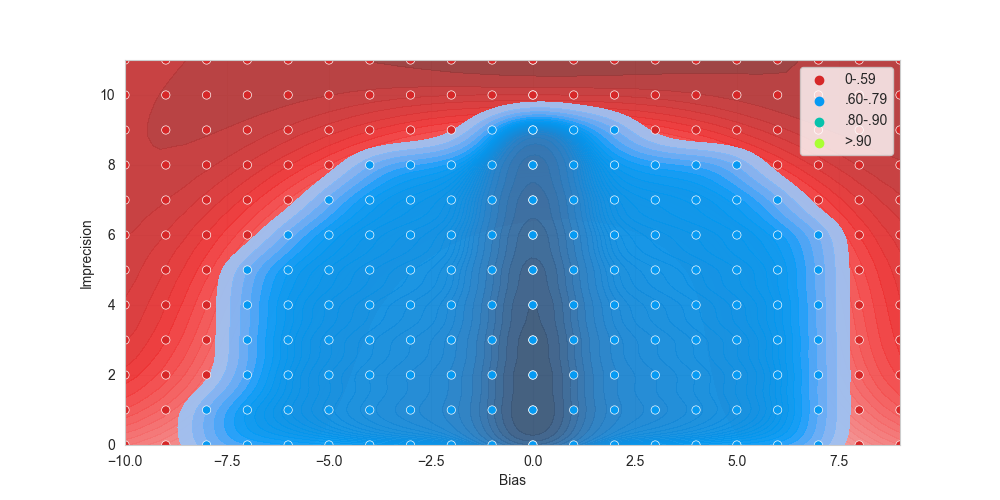

In [16]:
# percentage unit conversion by multiplying 100
error_kappa_table_2_v3 = error_kappa_table_2_v2[['Imprecision','Bias','Accuracy (Agreement)']].apply(lambda x: x*100) # percentage unit conversion
error_kappa_table_2_v3 = pd.concat([error_kappa_table_2_v3, error_kappa_table_2_v2[['Kappa Category','Kappa Score']]], axis = 1) # concat 

                                              
# contour plot
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 5))
palette = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
palette2 = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
sns.kdeplot(data=error_kappa_table_2_v3, x="Bias",y = "Imprecision",hue = 'Kappa Category', fill=True
            ,palette=palette, common_norm=False,levels=30, alpha=0.95,warn_singular=False, bw_adjust=0.5
            ,bw_method='scott',weights='Kappa Score')
sns.scatterplot(data=error_kappa_table_2_v3, x="Bias",y = "Imprecision", hue = 'Kappa Category' ,palette=palette2)


error_kappa_table_3_v3 = error_kappa_table_2_v3[error_kappa_table_2_v3['Kappa Score']>=0.60] # for x and y axis limit adjustment 
limit_xn = error_kappa_table_3_v3['Bias'].min()
limit_xp = error_kappa_table_3_v3['Bias'].max()
ylim_v1 = error_kappa_table_3_v3['Imprecision'].max()

plt.xlim(limit_xn-2, limit_xp +2)
plt.ylim(0, ylim_v1+2)
plt.legend(loc='upper right')

In [17]:
# APS for İmprecision, Bias

# APS levels allocation based on Kappa value
error_kappa_table_3 = error_kappa_table_2_v2[(error_kappa_table_2_v2['Kappa Score']>=0.60) & (error_kappa_table_2_v2['Kappa Score']<0.80)]
error_kappa_table_4 = error_kappa_table_2_v2[(error_kappa_table_2_v2['Kappa Score']>=0.8) & (error_kappa_table_2_v2['Kappa Score']<0.9)]
error_kappa_table_5 = error_kappa_table_2_v2[error_kappa_table_2_v2['Kappa Score']>0.9]

# generation of dataframe
data_aps = {'APS level': ['Minimum', 'Desirable', 'Optimum'],
        'Imprecision': [error_kappa_table_3['Imprecision'].max(), error_kappa_table_4['Imprecision'].max(), error_kappa_table_5['Imprecision'].max()],
       'Positive Bias': [error_kappa_table_3['Bias'].max(), error_kappa_table_4['Bias'].max(), error_kappa_table_5['Bias'].max()],
       'Negative Bias': [error_kappa_table_3['Bias'].min(), error_kappa_table_4['Bias'].min(), error_kappa_table_5['Bias'].min()],
        'Minimum Accuracy (Agreement)': [error_kappa_table_3['Accuracy (Agreement)'].min(), error_kappa_table_4['Accuracy (Agreement)'].min(), error_kappa_table_5['Accuracy (Agreement)'].min()],
           'Maximum Accuracy (Agreement)': [error_kappa_table_3['Accuracy (Agreement)'].max(), error_kappa_table_4['Accuracy (Agreement)'].max(), error_kappa_table_5['Accuracy (Agreement)'].max()]}
data_aps = pd.DataFrame(data_aps)

data_aps.loc[data_aps['Positive Bias'] < 0, 'Positive Bias'] = 0 # replace values are not found > 0 with 0

data_aps_v2= data_aps[['Imprecision','Positive Bias','Negative Bias','Minimum Accuracy (Agreement)', 'Maximum Accuracy (Agreement)']]*100

# APS level as first column 
data_aps_v2['APS level'] = ['Minimum (%)', 'Desirable (%)', 'Optimum (%)']
first_column = data_aps_v2.pop('APS level') 
data_aps_v2.insert(0, 'APS level', first_column)


data_aps_v2.iloc[:1,:4]


,APS level,Imprecision,Positive Bias,Negative Bias
0,Minimum (%),9.0,7.0,-8.0


# 

# ---------------------------------------------------------------------------------------
# End of APS Calculation
# ---------------------------------------------------------------------------------------